# Redes neuronales en un problema de regresión

En este notebook vamos a estudiar cómo utilizar una red neuronal de tipo perceptrón multicapa en un problema de regresión.

In [ ]:
RANDOM_STATE=333

## Conjunto de datos

En este caso vamos a trabajar con un conjunto de datos que describe el precio de las casas en Bostón en función de un conjunto de variables que describen sus características (1980):

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html

In [ ]:
from sklearn.datasets import load_boston

boston = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
import pandas as pd

df = pd.DataFrame(data=boston['data'], columns=boston['feature_names']) 
df['target'] = boston['target']

df.head()

CRIM    ZN  INDUS  CHAS    NOX  ...    TAX  PTRATIO       B  LSTAT  target
0  0.00632  18.0   2.31   0.0  0.538  ...  296.0     15.3  396.90   4.98    24.0
1  0.02731   0.0   7.07   0.0  0.469  ...  242.0     17.8  396.90   9.14    21.6
2  0.02729   0.0   7.07   0.0  0.469  ...  242.0     17.8  392.83   4.03    34.7
3  0.03237   0.0   2.18   0.0  0.458  ...  222.0     18.7  394.63   2.94    33.4
4  0.06905   0.0   2.18   0.0  0.458  ...  222.0     18.7  396.90   5.33    36.2

[5 rows x 14 columns]

In [ ]:
df.describe().transpose()

count        mean         std  ...        50%         75%       max
CRIM     506.0    3.613524    8.601545  ...    0.25651    3.677083   88.9762
ZN       506.0   11.363636   23.322453  ...    0.00000   12.500000  100.0000
INDUS    506.0   11.136779    6.860353  ...    9.69000   18.100000   27.7400
CHAS     506.0    0.069170    0.253994  ...    0.00000    0.000000    1.0000
NOX      506.0    0.554695    0.115878  ...    0.53800    0.624000    0.8710
RM       506.0    6.284634    0.702617  ...    6.20850    6.623500    8.7800
AGE      506.0   68.574901   28.148861  ...   77.50000   94.075000  100.0000
DIS      506.0    3.795043    2.105710  ...    3.20745    5.188425   12.1265
RAD      506.0    9.549407    8.707259  ...    5.00000   24.000000   24.0000
TAX      506.0  408.237154  168.537116  ...  330.00000  666.000000  711.0000
PTRATIO  506.0   18.455534    2.164946  ...   19.05000   20.200000   22.0000
B        506.0  356.674032   91.294864  ...  391.44000  396.225000  396.9000
LSTAT    506.0   12.653063    7.141062  ...   11.36000   16.955000   37.9700
target   506.0   22.532806    9.197104  ...   21.20000   25.000000   50.0000

[14 rows x 8 columns]

En este dataset no tenemos demasiadas variables. Si hubiera demasiadas variables podríamos seleccionar las que estén más correladas con la variable target. 

Aunque es importante tener en cuenta que una baja correlación lineal no necesariamente nos indica que el MLP no vaya a ser capaz de usar con éxito la variable para predecir, ya que los MLP son capaces de explotar la no linealidad de los datos.

In [ ]:
# buscamos las variables más correladas con la variable a predecir (target)
correl=df.corr()
correl['target']

# para mostrar sólo las que superen cierto umbral de correlación
#correl[abs(correl['target']) > 0.5]['target']

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
target     1.000000
Name: target, dtype: float64

<AxesSubplot:>

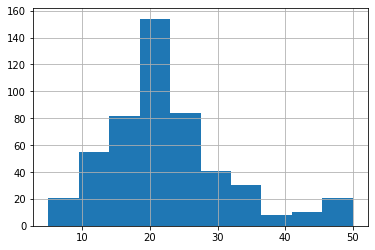

In [ ]:
df.target.hist()

Observamos una distribución asimétrica a la derecha y con un número de observaciones anormalmente alto en la última barra.

## Reescalado de los datos

Cuando trabajamos con redes neuronales suele ser una buena idea reescalar los datos para facilitar que el entrenamiento converja más rápidamente.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Transformamos las variables de entrada
scaler_x = StandardScaler()
scaler_x.fit(boston.data)
boston_scaled=scaler_x.transform(boston.data)

# Y también transformamos la variable de salida
scaler_y = StandardScaler()
scaler_y.fit(boston.target.reshape(-1, 1)) # Como es una sola variable es necesario ponerlo en modo columna
target_scaled=scaler_y.transform(boston.target.reshape(-1, 1))

## Buscamos el mejor coeficiente de regularización usando validación cruzada

De todos los parámetros que podemos configurar en la red neuronal (capas, neuronas, funciones de activación, regulación, tasa de aprendizaje, ...) nosotros sólo vamos optimizar el coeficiente de regularización.

Vamos a explorar una red con una capa oculta con 100 neuronas, función de activación ReLU, tamaño de mini-batch 100, tasa de aprendizaje 0.1, y máximo de 500 iteraciones a los datos (epochs).

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

cv_scores_mean=[]
cv_scores_std=[]

# Entrenar y validar distintas configuraciones
regul_param_range = np.arange(0.1, 2.1, step=0.2) # [0.5, 0.75,  ..., 2]
for regul_param in regul_param_range:
    # Aumentamos el parámetro max_iter hasta que converja
    mlp=MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=regul_param, batch_size=100, 
             learning_rate='constant', learning_rate_init=0.001, max_iter=500, random_state=RANDOM_STATE)
    
    # El error es neg_mean_squared_error el MSE en negativo!! Más pequeño peor.
    scores = cross_val_score(mlp, boston_scaled, target_scaled.ravel(), cv=5, scoring='neg_mean_squared_error')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([-0.256329653316279,
  -0.23139636773984879,
  -0.23460466432570376,
  -0.23617906085701862,
  -0.2428085895190602,
  -0.2512958921464023,
  -0.25844426882733584,
  -0.26553487335899056,
  -0.27735193026693256,
  -0.28748996491670903],
 [0.16143352836399807,
  0.19915817115410595,
  0.2112731786094604,
  0.20975309164396921,
  0.21337732064712242,
  0.2140075087081009,
  0.21429440570172406,
  0.2144289669240964,
  0.212264595201116,
  0.21578657210629515])

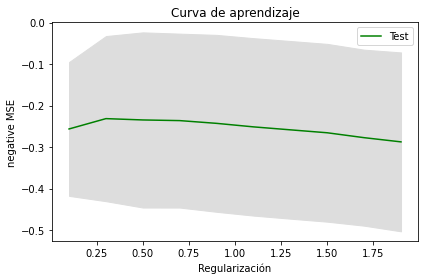

In [ ]:
import matplotlib.pyplot as plt

# Dibujamos la línea de la exactitud media en las partes de test
plt.plot(regul_param_range, cv_scores_mean, color="g", label="Test")

# Dibujamos la banda de la desviación típica
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(regul_param_range, lower_limit, upper_limit, color="#DDDDDD")

# Creamos el gráfico
plt.title("Curva de aprendizaje")
plt.xlabel("Regularización"), plt.ylabel("negative MSE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Podemos obsevar un comportamiento bastante estable para este parámetro en el rango observado. 

El mejor valor (el más cercano a cero) es con $\alpha=0.3$ y la desviación típica es similar a la que se ve con otros valores, aunque bastante elevada en general, lo que quiere decir que ha habido bastante variabilidad en cada una de las partiiciones de la validación cruzada en k partes.

## Análisis del error

Vamos a estudiar con un poco más de detalle la distribución de los errores. Para hacerlo vamos a obtener predicciones de los precios de todas las casas usando validación cruzada con la función `cross_val_predict` y usando .

In [ ]:
from sklearn.model_selection import cross_val_predict

# Creamos el clasificador
regul_param=0.3
mlp = MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=regul_param, batch_size=100, 
             learning_rate='constant', learning_rate_init=0.001, max_iter=500, random_state=RANDOM_STATE)
    
# estimamos 
predicts_scaled = cross_val_predict(mlp, boston_scaled, target_scaled.ravel(), cv=10)

# desescalamos las predicciones para que estén en la escala original
predicts=scaler_y.inverse_transform(predicts_scaled.reshape(1, -1))

In [ ]:
errors = np.abs(boston.target - predicts) # error en cada ejemplo
mean_error = np.mean(errors)
std_error = np.std(errors)
mean_price = np.mean(boston['target'])

print('Error absolute medio:', mean_error)
print('Desviación típica:', std_error)
print('Error absoluto medio en % sobre la media:', mean_error/mean_price*100)

Error medio: 3.2071242142978504
Desviación típica: 3.4172705040020404
Error medio en %: 14.233132651862125


Nuestro modelo comete un error medio de 3312$ con una desviación típica muy grande. Seguramente un error medio del 14.7\% no es muy buen resultado.

In [ ]:
# Podemos calcular el error también a partir de las métricas de sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print('MAE:', mean_absolute_error(boston.target, predicts.reshape(-1,1)))
print('RMSE:', np.sqrt(mean_squared_error(boston.target, predicts.reshape(-1,1))))
print('MAPE:', mean_absolute_percentage_error(boston.target, predicts.reshape(-1,1)))

MAE: 3.2071242142978504
RMSE: 4.686510794125835
MAPE: 0.17189791388473105


El MAE es el mismo valor que calculamos arriba. El MAPE no es exactamente igual e indica la media del error porcentual cometido para cada observación (un 17%), que es bastante elevado. El valor sensiblemente más alto del RMSE en comparación con el MAE nos indica que seguramente haya unos pocos errores "grandes", es decir, donde la desviación de la predicción con respecto al valor observada sea alta.

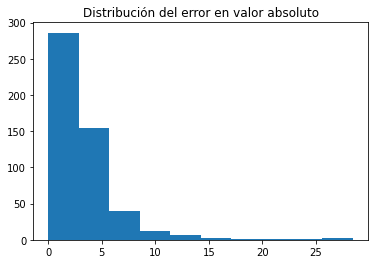

In [ ]:
# Dibujamos el histograma de los errores
fig1 = plt.figure()
ax1 = plt.axes()
ax1.hist(errors.reshape(-1,1))

plt.title('Distribución del error en valor absoluto')
plt.show()

Aunque la mayor parte de los errores se concentran en la parte izquierda de la gráfica y son, por tanto, pequeños, también hay algunos errores demasiado elevados que no son deseables, como habíamos intuido que haría.

Vamos a dibujar la distancia entre el valor predicho por el modelo y el valor real en una gráfica. La diagonal representa error 0.

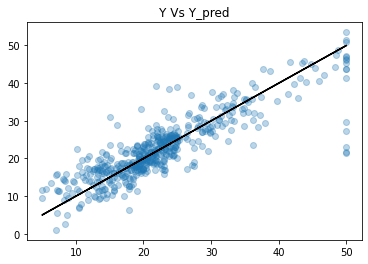

In [ ]:
fig2 = plt.figure()
ax2 = plt.axes()

# dibujamos los errores: la distancia a la recta indica el nivel de error
ax2.scatter(boston.target, predicts, alpha= 0.3) 
# Pintamos la referencia de la predicción perfecta
ax2.plot(boston.target, boston.target, color='k') 

plt.title('Y Vs Y_pred')
plt.show()

Al pintar el gráfico vemos que la mayor desviación se produce para los valores de Y=50, los cuales son infraestimados por el modelo. 

Quizás se pueda mejorar la estimación o quizás quiera decir que en vecindarios donde el precio de la vivienda debería ser más bajo existen viviendas muy caras.